# **Variational Algorithms for molecule simulations**
---

### **Description**
In this lab, we will see how to use VQE to simulate different molecules

<br>

### **Learning Objectives**
By the end of this lab, we will:
* Recognize what it means to simulate molecules.

* Learn how to implement VQE using Cirq to simulate molecules

**Before starting, run the code below to import all necessary functions and libraries.**


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import sympy

from math import radians, degrees
from scipy.optimize import minimize

try:
  from openfermionpyscf import run_pyscf
  from openfermion.transforms import jordan_wigner
  from openfermion.linalg import get_sparse_operator
  from openfermion import MolecularData
except ImportError:
  !pip install openfermion openfermionpyscf  --quiet
  from openfermionpyscf import run_pyscf
  from openfermion.transforms import jordan_wigner
  from openfermion.linalg import get_sparse_operator
  from openfermion import MolecularData

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]
plt.rcParams.update({'font.size': 8})

try:
    import cirq
    from cirq_web import bloch_sphere
    from cirq import Z, PauliSum
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    !pip install cirq-web --quiet
    import cirq
    from cirq_web import bloch_sphere
    from cirq import Z, PauliSum

    print("installed cirq.")


import warnings
warnings.filterwarnings("ignore")


print("Libraries Successfully Imported")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 10.2 MB/s eta 0:00:00
installing cirq...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.7 MB/s eta 0:00:00
installed cirq.
Libraries Successfully Imported


---
## **Part 1.1: Finding the Structure of a Molecule**
---

In this section, we will use VQE to determine the structure of the hydrogen molecule $H_2$. First initalize Hydrogen Molecule

In [ ]:
# Step 1: Define H₂ molecule
geometry = [("H", (0, 0, 0)), ("H", (0, 0, 0.735))]
molecule = MolecularData(geometry, basis='sto-3g', multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_scf=True, run_fci=True)

fermionic_ham = molecule.get_molecular_hamiltonian()
qubit_ham = jordan_wigner(fermionic_ham)
H_sparse = get_sparse_operator(qubit_ham)  # Automatically uses all 4 qubits

### **Setting Up VQE Ansatz**

**Independently**, set up the Ansatz for VQE. Specifically, create:
* 4 qubits (2 for the electrons in H2, and 2 for the protons in H2)
* x-rotation gates on all qubits
* Cnot gates between qubit 1 and 2, and a CNOT gate between qubit 3 and 4

In [ ]:

# Build a 4-qubit ansatz
qubits = cirq.LineQubit.range(4)
symbols = [sympy.Symbol(f'theta_{i}') for i in range(4)]

### Write your code here ####
circuit = cirq.Circuit()
for i in range(4):
    circuit.append(cirq.rx(symbols[i])(qubits[i]))
for i in range(3):
    circuit.append(cirq.CZ(qubits[i], qubits[i + 1]))


SyntaxError: invalid syntax (<ipython-input-3-80927d5e6148>, line 6)

### **Set up VQE simulator**

Now, we will set up the Ansatz for VQE. Specifically, create:
* Initilize the cirq simulator
* create a function called expectation value and use the simulator to get results from your circuit
* convert the final results into a state vector (check out the cheatsheet)

In [ ]:
# Expectation value function
sim = cirq.Simulator()

def expectation(params):
    resolver = cirq.ParamResolver({str(symbols[i]): params[i] for i in range(4)})
    result = sim.simulate(circuit, resolver)
    psi = ### convert the results into a state vector
    return np.real(psi.conj().T @ (H_sparse @ psi))  # shape-matched matmul

Finally, use a classical minimizer to optimize the parameters of your rotation gates, so that you get the minimum energy value

In [ ]:
x0 = np.random.uniform(0, 2*np.pi, 4)
res = minimize(expectation, x0=x0, method='COBYLA', options={'maxiter': 300})

print("VQE Total energy =", res.fun)

Unlike the knapsack problem, it's difficult for us to determine if this solution is correct just by looking at it. So, let's use an exact solver that is guaranteed to give us the correct answer.

In [ ]:
# Assuming fermionic_ham is already defined and jordan_wigner() applied:
qubit_ham = jordan_wigner(fermionic_ham)

# Convert to sparse matrix representation
H_sparse = get_sparse_operator(qubit_ham)  # full matrix for all required qubits

# Convert to dense matrix (for exact diagonalization)
H_dense = H_sparse.toarray()

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H_dense)

# Ground state energy = lowest eigenvalue
ground_energy = eigenvalues[0]

print("Total energy =", ground_energy)

In [ ]:
error_percent = (ground_energy - res.fun) / ground_energy * 100
print(f"% Error = {error_percent:.4f} %")

## **Part 1.2: Finding the Optimal Distance of a Molecule**

We just learned how to calculate the molecule ground state for a given bond length. Now, let's find the energies for many distances between these two hydrogen atoms, and in the process, find the lowest possible energy. The distance at which we get the lowest energy corresponds to the ground state (ideal) bond length of the hydrogen molecule!

**Run the cells below to setup this problem and then calculate the energies for each distance using both exact and VQE solvers.**

In [ ]:
# Step 1: Bond distances
bond_distances = np.linspace(0.2, 2.5, 12)
vqe_energies = []
exact_energies = []

for dist in bond_distances:
    print(f"\nSimulating H₂ at bond length = {dist:.2f} Å")

    # Step 2: Build molecule
    geometry = [("H", (0, 0, 0)), ("H", (0, 0, dist))]
    molecule = MolecularData(geometry, basis='sto-3g', multiplicity=1, charge=0)
    molecule = run_pyscf(molecule, run_scf=True, run_fci=True)

    # Step 3: Hamiltonian
    fermionic_ham = molecule.get_molecular_hamiltonian()
    qubit_ham = jordan_wigner(fermionic_ham)
    H_sparse = get_sparse_operator(qubit_ham)

    # Step 4: Setup ansatz and qubits
    n_qubits = int(np.log2(H_sparse.shape[0]))
    qubits = cirq.LineQubit.range(n_qubits)
    symbols = [sympy.Symbol(f'theta_{i}') for i in range(n_qubits)]
    circuit = cirq.Circuit()
    for i in range(n_qubits):
        circuit.append(cirq.rx(symbols[i])(qubits[i]))
    for i in range(n_qubits - 1):
        circuit.append(cirq.CZ(qubits[i], qubits[i + 1]))

    simulator = cirq.Simulator()

    def expectation(params):
        resolver = cirq.ParamResolver({str(symbols[i]): params[i] for i in range(len(symbols))})
        result = simulator.simulate(circuit, resolver)
        psi = result.final_state_vector
        return np.real(psi.conj().T @ (H_sparse @ psi))

    # Step 5: Run VQE
    x0 = np.random.uniform(0, 2 * np.pi, len(symbols))
    res = minimize(expectation, x0=x0, method='COBYLA', options={'maxiter': 1000})
    vqe_energies.append(res.fun)

    H_sparse = get_sparse_operator(qubit_ham)
    H_dense = H_sparse.toarray()
    eigvals, _ = np.linalg.eigh(H_dense)
    exact_energies.append(eigvals[0])

# Step 6: Plot
plt.plot(bond_distances, vqe_energies, label='VQE Energy', marker='x')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H₂ Potential Energy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now lets use linear algebra to manually calcualte the energies at each bond-length. This is basically finding eigenstates from the Hamiltonian matrix.

In [ ]:
bond_distances = np.linspace(0.2, 2.5, 12)
exact_energies = []

### Calculate exact energies
for dist in bond_distances:
    # Step 3: Build molecule
    geometry = [("H", (0, 0, 0)), ("H", (0, 0, dist))]
    molecule = MolecularData(geometry, basis='sto-3g', multiplicity=1, charge=0)
    molecule = run_pyscf(molecule, run_scf=True, run_fci=True)

    # Step 4: Hamiltonian
    fermionic_ham = molecule.get_molecular_hamiltonian()
    qubit_ham = jordan_wigner(fermionic_ham)
    H_sparse = get_sparse_operator(qubit_ham)
    H_dense = H_sparse.toarray()
    eigvals, _ = np.linalg.eigh(H_dense)
    exact_energies.append(eigvals[0])
    print(f"\nSolving H₂ at bond length = {dist:.2f} Å")


#### **Finally, lets plot our VQE data on top of the exact solution and see how they compare**

In [ ]:
plt.plot(bond_distances, exact_energies, label='Exact FCI Energy', marker='o')
plt.plot(bond_distances, vqe_energies, label='VQE Energy', marker='x')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H₂ Potential Energy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Independent: Finding the Optimal Distance of HF Molecule**

You just simulated the ground state energies of H2! Now try extending this to other molecules

**complete the code below to setup this problem for HF, then calculate the energies for each distance using both exact and VQE solvers.**


Simulating HF at bond length = 0.60 Å

Simulating HF at bond length = 0.87 Å

Simulating HF at bond length = 1.13 Å

Simulating HF at bond length = 1.40 Å

Simulating HF at bond length = 1.67 Å

Simulating HF at bond length = 1.93 Å

Simulating HF at bond length = 2.20 Å


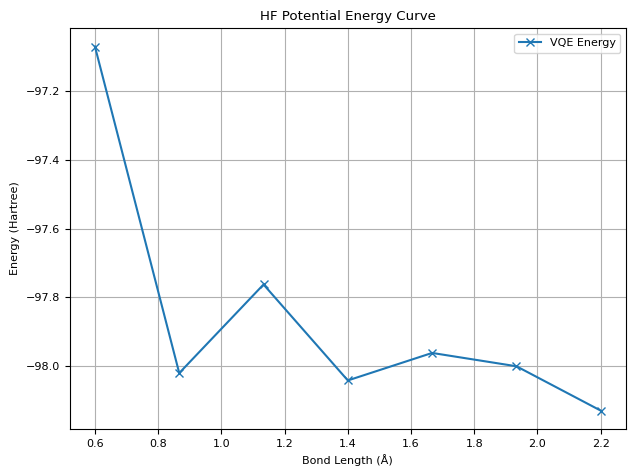

In [ ]:
# HF bond lengths to scan (in Angstroms)
bond_distances = np.linspace(0.6, 2.2, 7)
vqe_energies = []
exact_energies = []

for dist in bond_distances:
    print(f"\nSimulating HF at bond length = {dist:.2f} Å")

    # Step 1: Define HF molecule (linear)
    geometry = ######## complete this code ######
    molecule = MolecularData(
        geometry=geometry,
        basis='sto-3g',
        multiplicity=1,
        charge=0,
        description=f"{dist:.2f}A"
    )

    # Step 2: Freeze core and reduce orbitals. This makes it easier for VQE to solve
    molecule.active_space_start = 1   # skip 1s of F
    molecule.active_space_stop = 3    # 2 orbitals (lowest virtual)
    molecule.n_active_electrons = 2   # focus on bonding electrons

    molecule = run_pyscf(molecule, run_scf=True, run_fci=True)

    # Step 3: Transform to qubit Hamiltonian
    fermionic_ham = jordan_wigner(fermionic_ham)
    qubit_ham = molecule.get_molecular_hamiltonian()
    H_sparse = get_sparse_operator(qubit_ham)
    ######## complete this code ######

    # Step 4: Setup qubits and circuit
    n_qubits = int(np.log2(H_sparse.shape[0]))
    qubits = cirq.LineQubit.range(n_qubits)
    symbols = [sympy.Symbol(f"theta_{i}") for i in range(n_qubits)]

    circuit = cirq.Circuit()

    for i in range(n_qubits):
        circuit.append(cirq.rx(symbols[i])(qubits[i]))

    ####### complete this code: create the same ansatz as H2 ######
    #
    #
    #
    #


    # Step 5: Expectation function
    sim = cirq.Simulator()
    def expectation(params):
        resolver = cirq.ParamResolver({str(symbols[i]): params[i] for i in range(len(symbols))})
        result = sim.simulate(circuit, resolver)
        psi = result.final_state_vector
        return np.real(psi.conj().T @ (H_sparse @ psi))

    # Step 6: VQE
    x0 = np.random.uniform(0, 2*np.pi, len(symbols))
    result = minimize(expectation, x0=x0, method='COBYLA', options={'maxiter': 200})
    vqe_energies.append(result.fun)


# Step 8: Plot
plt.plot(bond_distances, vqe_energies, label='VQE Energy', marker='x')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('HF Potential Energy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Now use the exact solver to calculate the energy levels. Remember, it is using large matrix multiplications

In [ ]:
bond_distances = np.linspace(0.2, 2.5, 12)
exact_energies = []

### Calculate exact energies
for dist in bond_distances:
    # Step 3: Build molecule
    geometry = [("H", (0, 0, 0)), ("F", (0, 0, dist))]
    molecule = MolecularData(geometry, basis='sto-3g', multiplicity=1, charge=0)
    molecule = run_pyscf(molecule, run_scf=True, run_fci=True)

    # Step 4: Hamiltonian
    fermionic_ham = molecule.get_molecular_hamiltonian()
    qubit_ham = jordan_wigner(fermionic_ham)
    H_sparse = get_sparse_operator(qubit_ham)
    H_dense = H_sparse.toarray()
    eigvals, _ = np.linalg.eigh(H_dense)
    exact_energies.append(eigvals[0])
    print(f"\nSolving H₂ at bond length = {dist:.2f} Å")



Solving H₂ at bond length = 0.20 Å

Solving H₂ at bond length = 0.41 Å

Solving H₂ at bond length = 0.62 Å

Solving H₂ at bond length = 0.83 Å

Solving H₂ at bond length = 1.04 Å

Solving H₂ at bond length = 1.25 Å

Solving H₂ at bond length = 1.45 Å

Solving H₂ at bond length = 1.66 Å

Solving H₂ at bond length = 1.87 Å

Solving H₂ at bond length = 2.08 Å

Solving H₂ at bond length = 2.29 Å

Solving H₂ at bond length = 2.50 Å


## Notice anything? Seems like the exact solver can't even compute it anymore! The hamiltonian of our system is much larger because of the Fluorine atom. This makes it difficult for classical solvers

#End of notebook
---
© 2024 The Coding School, All rights reserved